<a href="https://colab.research.google.com/github/ITAM-DS/deep-learning/blob/ag%2Fclasificacion/02_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U d2l
from d2l import tensorflow as d2l
import tensorflow as tf
from IPython import display

     |████████████████████████████████| 81kB 3.8MB/s 


In [4]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

In [6]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

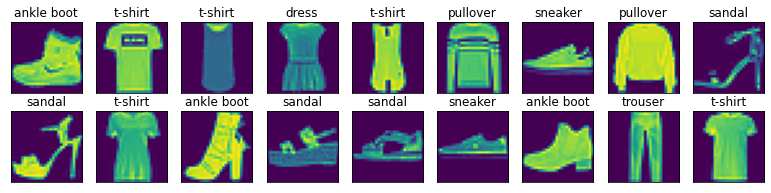

In [8]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

In [9]:
def load_data_fashion_mnist(batch_size, resize=None):   
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [10]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [11]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(256, 28, 28, 1) <dtype: 'float32'> (256,) <dtype: 'int32'>


In [12]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [13]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

In [14]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [15]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)

print(X.numpy())
print(X_prob.numpy()) 
print(tf.reduce_sum(X_prob, 1).numpy())

[[-0.19657311 -0.57013214  0.29987806  0.16978094  1.0732213 ]
 [-0.06393319 -0.72399855  0.63729393  0.05615267  0.24907029]]
[[0.11999403 0.08258954 0.19713588 0.1730873  0.42719325]
 [0.16588803 0.08573384 0.33446762 0.18705428 0.22685622]]
[1. 1.]


In [16]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

In [17]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [18]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

In [19]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [20]:
accuracy(y_hat, y) / len(y)

0.5

In [21]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

In [22]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [23]:
evaluate_accuracy(net, test_iter)

0.1005

In [24]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [25]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [26]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [27]:
class Updater():  #@save
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

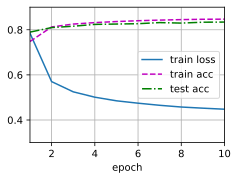

In [28]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

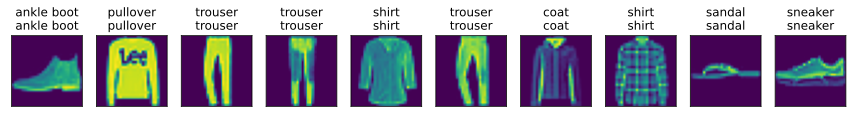

In [29]:
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter, n = 10)